<img src="./auxdata/eurac_EO.png" alt="EURAC Institute for Earth Observation" title="EURAC Institute for Earth Observation" width="300"/>

In this notebook we will use openEO to generate a cloud free RGB composite based on Sentinel-2 L2A data, using the S2_L2A_ALPS collection, which provides Sentinel-2 L2A data with a cloud mask layer generated with s2cloudless over the ALps.

In [24]:
import openeo
from openeo.rest.datacube import PGNode, THIS
from openeo.processes import mean, eq, median, or_, array_element, clip
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

Connect to the EURAC openEO back-end

In [2]:
euracEndpoint = "https://openeo.eurac.edu"
conn = openeo.connect(euracEndpoint).authenticate_oidc(client_id="openEO_PKCE")

Authenticated using refresh token.


You can get detailed metadata about the Sentinel-2 collection with the following code:

In [3]:
conn.describe_collection('S2_L2A_ALPS')

{'stac_version': '0.9.0',
 'stac_extensions': ['datacube', 'scientific'],
 'type': 'Collection',
 'id': 'S2_L2A_ALPS',
 'title': 'Sentinel-2 L2A over the Alps',
 'description': 'Sentinel-2 L2A data processed using Sen2Cor over the Alps. This collection includes the UTM tiles T31TFJ,T31TFK,T31TFL,T31TGJ,T31TGK,T31TGL,T31TGM,T32TLP,T32TLQ,T32TLR,T32TLS,T32TMP,T32TMQ,T32TMR,T32TMS,T32TMT,T32TNR,T32TNS,T32TNT,T32TPR,T32TPS,T32TPT,T32TQR,T32TQS,T32TQT,T32UNU,T32UPU,T32UQU,T33TUL,T33TUM,T33TUN,T33TVL,T33TVM,T33TVN,T33TWM,T33TWN,T33TXN,T33UUP,T33UVP,T33UWP. This collection includes all the Sentinel-2 bands in 10 meters resolution and a CLOUD_MASK band generated by s2cloudless, where the clouds have values 1 and no clouds 0. The original bands that would have 20m or 60m resolution have been resampled to 10m using a nearest neighbor interpolation automatically by ODC.',
 'keywords': ['Copernicus'],
 'deprecated': False,
 'license': 'CC-BY-4.0',
 'sci:citation': 'Copyright holder: European Environment Agency (EEA)',
 'providers': [{'name': 'Eurac EO ODC',
   'url': 'https://www.eurac.edu',
   'roles': ['host', 'producer']},
  {'name': 'European Environment Agency (EEA)',
   'url': 'mailto:copernicus@eea.europa.eu',
   'roles': ['producer']}],
 'extent': {'spatial': {'bbox': [[4.232032700036687,
     43.20121135494447,
     17.802846682912055,
     48.75301300400106]]},
  'temporal': {'interval': [['2015-07-04T10:13:37.922Z',
     '2022-06-12T10:18:16.647007Z']]}},
 'links': [{'rel': 'licence',
   'href': 'https://creativecommons.org/licenses/by/4.0/',
   'type': 'text/html',
   'title': 'License Link'}],
 'cube:dimensions': {'DATE': {'type': 'temporal',
   'extent': ['2015-07-04T10:13:37.922000+00:00',
    '2022-06-12T10:18:16.647007+00:00']},
  'X': {'type': 'spatial',
   'axis': 'x',
   'extent': [4.232032700036687, 17.802846682912055],
   'reference_system': 4326},
  'Y': {'type': 'spatial',
   'axis': 'y',
   'extent': [43.20121135494447, 48.75301300400106],
   'reference_system': 4326},
  'bands': {'type': 'bands',
   'values': ['AOT',
    'B01',
    'B02',
    'B03',
    'B04',
    'B05',
    'B06',
    'B07',
    'B08',
    'B09',
    'B11',
    'B12',
    'B8A',
    'SCL',
    'WVP',
    'CLOUD_MASK']}},
 'summaries': {'gsd': [10.0]}}

Set the temporal extent we want to consider

In [5]:
temporal_extent = ["2021-05-01","2021-09-01"]

Set the spatial extent (area around Bolzano as an example)

In [6]:
spatial_extent = { "west": 11.071590350000491,"east": 11.588542226063511,"south": 46.40991407331259,"north": 46.56346581927167}

Set the collection name for the Sentinel-2 data

In [7]:
S2_collection = 'S2_L2A_ALPS'

Set the bands we want to load

In [8]:
bands = ['B02','B03','B04','CLOUD_MASK']

Load the S2 data:

In [9]:
S2_data = conn.load_collection(S2_collection,temporal_extent=temporal_extent,bands=bands,spatial_extent=spatial_extent)#.filter_bbox(spatial_extent)

We need to mask out (setting it to not a number) the zero values, i.e. where there is no data. 

In [10]:
data_mask = S2_data.filter_bands('B04').reduce_dimension(dimension="bands",reducer = lambda value: eq(array_element(value,0),0))
S2_L1C_masked = S2_data.mask(data_mask)

We create a mask for clouds (CLOUD_MASK == 1).

In [11]:
cloud_mask = S2_data.filter_bands('CLOUD_MASK').reduce_dimension(dimension="bands",reducer = lambda value: eq(array_element(value,0),1))

Apply the mask to the S2 data

In [12]:
S2_L1C_masked = S2_L1C_masked.filter_bands(['B02','B03','B04']).mask(cloud_mask)

Compute the median over time

In [13]:
S2_data_masked_median = S2_L1C_masked.reduce_dimension(dimension='DATE',reducer=median)

Clip the data between 0 and 1800 for a better visualization

In [14]:
S2_data_masked_median_clipped = S2_data_masked_median.apply(lambda value: value.clip(0,1800))

Save the result as geoTIFF

In [15]:
S2_data_masked_median_nc = S2_data_masked_median_clipped.save_result(format='GTIFF')

Start a batch job and wait until it is marked as finished

In [16]:
job_title = 'S2_L2A_RGB_cloud_free_composite'
job = conn.create_job(S2_data_masked_median_nc,title=job_title)
job_id = job.job_id
if job_id:
    print('Batch job created with id: ',job_id)
    job.start_job()
else:
    print('Error! Job ID is None')

Batch job created with id:  c6fcaed1-0ddf-450d-b054-563ebc5efd03


In [26]:
job = conn.job(job_id)
job

<RESTJob job_id='c6fcaed1-0ddf-450d-b054-563ebc5efd03'>

Download the result

In [27]:
results = job.get_results()
results.download_files('./results/')

[PosixPath('results/result.tiff'),
 PosixPath('results/process.json'),
 PosixPath('results/job-results.json')]

Tone mapping function for a nicer RGB visualization:

In [18]:
def tone_mapping(B04,B03,B02):
    red = B04.values
    green = B03.values
    blue = B02.values
    red = (red+1)/1733*255
    green = (green+1)/1630*255
    blue = (blue+1)/1347*255
    red = np.clip(red,0,255).astype(np.uint8)
    green = np.clip(green,0,255).astype(np.uint8)
    blue = np.clip(blue,0,255).astype(np.uint8)
    brg = np.zeros((red.shape[0],red.shape[1],3),dtype=np.uint8)
    brg[:,:,0] = red
    brg[:,:,1] = green
    brg[:,:,2] = blue
    return brg

Open the result

In [28]:
result = xr.open_dataarray('results/result.tiff')
result

<xarray.DataArray 'band_data' (band: 3, y: 1824, x: 4018)>
[21986496 values with dtype=float32]
Coordinates:
  * band         (band) int64 1 2 3
  * x            (x) float64 6.588e+05 6.588e+05 ... 6.989e+05 6.989e+05
  * y            (y) float64 5.142e+06 5.142e+06 5.142e+06 ... 5.16e+06 5.16e+06
    spatial_ref  int64 ...
Attributes:
    STATISTICS_MAXIMUM:        1800
    STATISTICS_MEAN:           319.33622185637
    STATISTICS_MINIMUM:        1
    STATISTICS_STDDEV:         225.81625681977
    STATISTICS_VALID_PERCENT:  100
    long_name:                 ('B02', 'B03', 'B04')

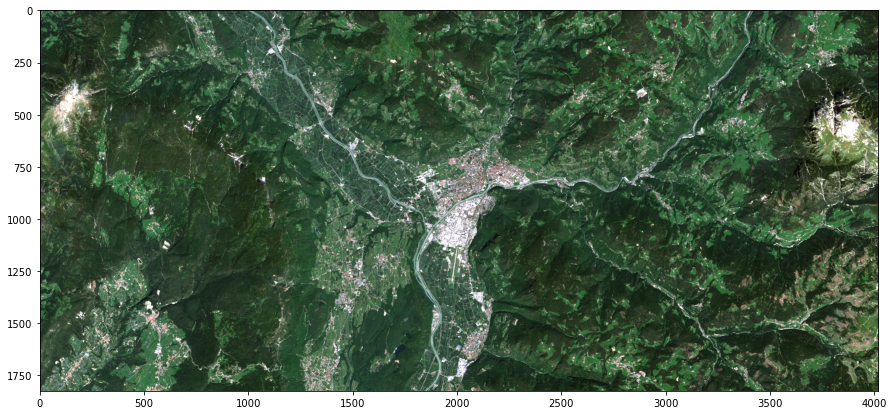

In [37]:
rgb = tone_mapping(result[2],result[1],result[0])
fig, ax = plt.subplots(figsize=(18, 7))
ax.imshow(np.flipud(rgb))
plt.show()